## 循环神经网络的高级用法

### 温度预测问题（加载数据）

数据集中每10分钟记录14个不同的量，其中包含多年的记录。

输入最近的一些数据（几天的数据点），来预测24小时之后的气温。

In [1]:
import os 

data_dir = '/home/bingli/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

In [3]:
headers

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [4]:
len(lines)

420551

In [5]:
lines[:5]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30']

In [6]:
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [7]:
float_data = np.zeros((len(lines), len(headers) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [8]:
float_data[:5]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02],
       [ 9.96510e+02, -8.31000e+00,  2.65120e+02, -9.07000e+00,
         9.42000e+01,  3.26000e+00,  3.07000e+00,  1.90000e-01,
         1.92000e+00,  3.08000e+00,  1.30919e+03,  3.40000e-01,
         5.00000e-01,  1.98000e+02],
       [ 9.96510e+02, -8.27000e+00,  2.65150e+02, -9.04000e+00,
         9.41000e+01

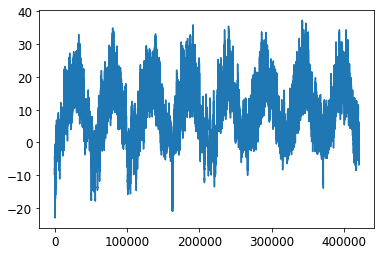

In [9]:
# 绘制温度时间序列
temp = float_data[:, 1]  # 温度
plt.plot(range(len(temp)), temp)
plt.show()

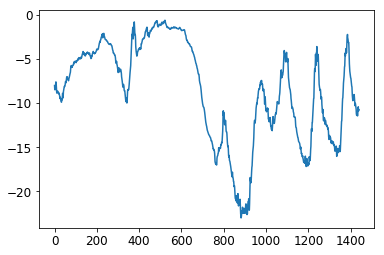

In [10]:
# 绘制前10天的温度时间序列
plt.plot(range(1440), temp[:1440])
plt.show()

### 准备数据

In [11]:
# standard，前200000个时间步作为训练数据
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [12]:
# 生成时间序列样本及其目标的生成器


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    """生成一个元组(samples, targets)，其中samples是输入数据的一个批量，targets是对应
    的目标温度数据。
    data: 浮点数据组成的原始数组
    lookback：输入数据应该包括过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    min_index和max_index：data数组中的索引，用于界定需要抽取哪些时间步
    shuffle：打乱样本，还是按顺序抽取样本
    step：数据采样的周期（单位：时间步）
    batch_size：每个批量的样本数"""
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indics = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indics]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [13]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000,
                    step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None,
                     step=step, batch_size=batch_size)

In [14]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size   # 769

# This is how many steps to draw from 'test_gen'
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size   # 930

### 一种基于常识的、非机器学习的基准方法

在建立机器学习方法之前，建立一个基于常识的基准方法是很有用的。

温度时间序列是连续的，并且具有每天的周期性变化。**一种基于常识的方法就是始终预测24小时后的温度等于现在的温度。使用平均绝对误差（MAE）指标来评估这种方法。**

In [15]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


evaluate_naive_method()

0.2897359729905486


In [16]:
# 将MAE转化为摄氏温度误差
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

因为温度数据被标准化成均值为0、标准差为1，所以无法直接对MAE进行解释。它转化为温度的平均绝对误差为$0.29 \times temperature\_std$摄氏度，$2.57^{\circ}C$。

> **遇到新问题时，最好首先为选择的指标建立一个基于常识的基准。如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步。**

### 一种基本的机器学习方法

在开始研究复杂且计算代价很高的模型（比如RNN）之前，尝试使用简单且计算代价低的机器学习模型也是很有用，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

In [17]:
# 训练一个密集连接模型
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.3511 - val_loss: 1.0121
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.4810 - val_loss: 0.3497
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3000 - val_loss: 0.3108
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2695 - val_loss: 0.3025
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2561 - val_loss: 0.3146
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2451 - val_loss: 0.3038
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2373 - val_loss: 0.3178
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2304 - val_loss: 0.3170
Epoch 9/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2301 - val_loss: 0.3513
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.224

In [18]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

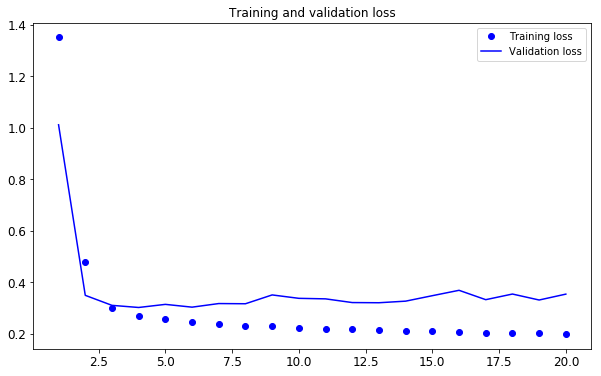

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

将时间序列展平，从输入数据中删除了时间的概念。

> **在尝试代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有意义的。有时简单模型就是你的最佳选择。**

**如果时间顺序对于数据很重要，那么循环网络是一种很适合的方法，与那些先将时间数据展平的模型相比，其性能要更好。**

### 循环网络基准

门控循环单元（GRU，gated recurrent unit），工作原理与LSTM相同，但做了一些简化，因此运行的计算代价更低（虽然表示能力不如LSTM）。

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 124s 248ms/step - loss: 0.3042 - val_loss: 0.2704
Epoch 2/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2865 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2794 - val_loss: 0.2643
Epoch 4/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2739 - val_loss: 0.2692
Epoch 5/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2692 - val_loss: 0.2636
Epoch 6/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2631 - val_loss: 0.2694
Epoch 7/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2595 - val_loss: 0.2675
Epoch 8/20
500/500 [==============================] - 122s 245ms/step - loss: 0.2542 - val_loss: 0.2680
Epoch 9/20
500/500 [==============================] - 123s 245ms/step - loss: 0.2505 - val_loss: 0.2718
Epoch 10/20
500/500 [==============================] - 123s 245m

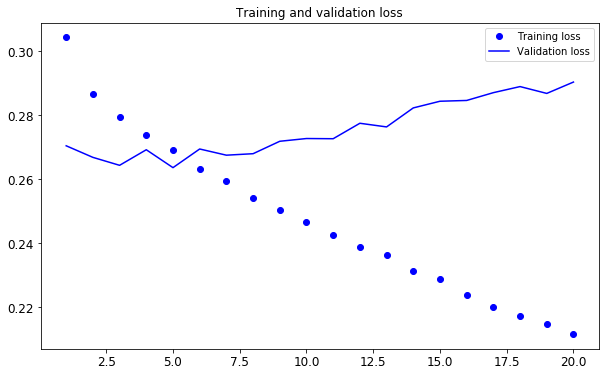

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

> 新的验证MAE约为0.265（在开始显著过拟合之前）。  
几轮过后模型开始过拟合——训练损失和验证损失就开始显著偏离。

### 使用循环Dropout来降低过拟合

**dropout**，将某一层的输入单元随机设为0，其目的是打破该层训练数据中的偶然相关性。

在循环层之前应用dropout，这种正则化会妨碍学习过程，而不是有所帮助。

在循环层正确使用dropout的正确方法：对每个时间步应该使用相同的dropout掩码（dropout mask，相同模式的舍弃单元），而不是让dropout掩码随着时间步的增加而随机变化。此外，为了对LSTM和GRU等循环层得到的表示做正则化，应该将不随时间变化的dropout掩码应用于层的内部循环激活（叫作**循环dropout掩码**）。对每个时间步使用相同的dropout掩码，可以让网络沿着时间正确地传播其学习误差，而随着时间随机变化的dropout掩码则会破坏这个误差信号，并不利于学习过程。

Keras的每个循环层都有两个与dropout相关的参数：
1. dropout，浮点数，指定该层输入单元的dropout比率
2. recurrent_dropout，指定循环单元的dropout比率。

使用dropout正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的2倍。

In [22]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 139s 277ms/step - loss: 0.3421 - val_loss: 0.2761
Epoch 2/40
500/500 [==============================] - 138s 276ms/step - loss: 0.3157 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 138s 276ms/step - loss: 0.3066 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 138s 276ms/step - loss: 0.3046 - val_loss: 0.2687
Epoch 5/40
500/500 [==============================] - 138s 276ms/step - loss: 0.3024 - val_loss: 0.2720
Epoch 6/40
500/500 [==============================] - 138s 276ms/step - loss: 0.2984 - val_loss: 0.2672
Epoch 7/40
500/500 [==============================] - 138s 276ms/step - loss: 0.2975 - val_loss: 0.2689
Epoch 8/40
500/500 [==============================] - 138s 276ms/step - loss: 0.2961 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 138s 276ms/step - loss: 0.2938 - val_loss: 0.2769
Epoch 10/40
500/500 [==============================] - 138s 276m

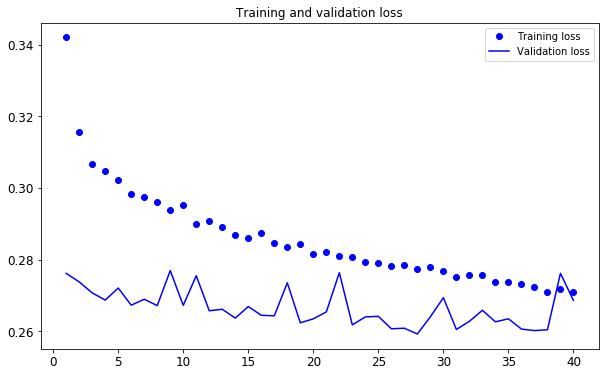

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

虽然评估分数稳定，但最佳分数并没有比之前低很多。

### 循环层堆叠

模型不再过拟合，但似乎遇到了性能瓶颈，所以应该考虑增加网络容量。**增加网络容量通常是一个好主意，直到过拟合变成主要的障碍。**只要过拟合不是太严重，那么很可能是容量不足的问题。

增加网络容量的通常做法是增加每层单元数或增加层数。**循环层堆叠**是构建更加强大的循环网络的经典方法。

In [24]:
# 训练并评估一个使用dropout正则化的堆叠GRU模型
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 280s 560ms/step - loss: 0.3357 - val_loss: 0.2799
Epoch 2/40
500/500 [==============================] - 278s 557ms/step - loss: 0.3124 - val_loss: 0.2780
Epoch 3/40
500/500 [==============================] - 278s 557ms/step - loss: 0.3052 - val_loss: 0.2747
Epoch 4/40
500/500 [==============================] - 279s 558ms/step - loss: 0.3019 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2970 - val_loss: 0.2751
Epoch 6/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2926 - val_loss: 0.2691
Epoch 7/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2918 - val_loss: 0.2708
Epoch 8/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2900 - val_loss: 0.2685
Epoch 9/40
500/500 [==============================] - 279s 557ms/step - loss: 0.2863 - val_loss: 0.2710
Epoch 10/40
500/500 [==============================] - 279s 557m

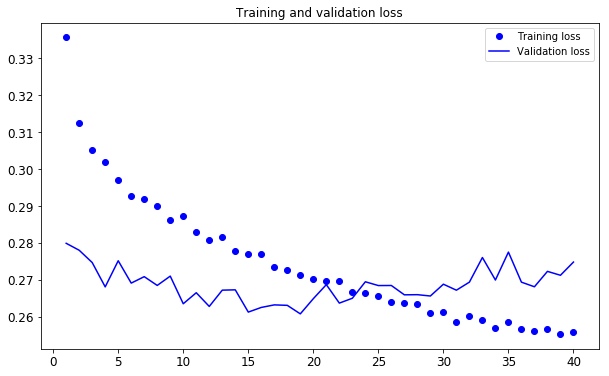

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

> **与单个RNN层相比，堆叠RNN的表示能力更加强大。但它的计算代价也更高，因此不一定总是需要。在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用。**

### 使用双向RNN

+ 使用逆序序列（IMDB）训练LSTM

In [26]:
# 使用逆序序列训练并评估一个LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000   # 作为特征的单词个数
maxlen = 500   # 在500个单词后截断文本

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [27]:
x_train.shape

(25000,)

In [28]:
x_train[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [29]:
len(x_train[0])

218

In [30]:
# 将序列反转
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

In [31]:
# 填充序列
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [32]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.4977 - acc: 0.7659 - val_loss: 0.5229 - val_acc: 0.7700
Epoch 2/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.3102 - acc: 0.8825 - val_loss: 0.4093 - val_acc: 0.8224
Epoch 3/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.2573 - acc: 0.9043 - val_loss: 0.3422 - val_acc: 0.8562
Epoch 4/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.2194 - acc: 0.9190 - val_loss: 0.3956 - val_acc: 0.8692
Epoch 5/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.1879 - acc: 0.9331 - val_loss: 0.3343 - val_acc: 0.8738
Epoch 6/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.1733 - acc: 0.9385 - val_loss: 0.3823 - val_acc: 0.8744
Epoch 7/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.1561 - acc: 0.9470 - val_loss: 0.6037 - val_acc:

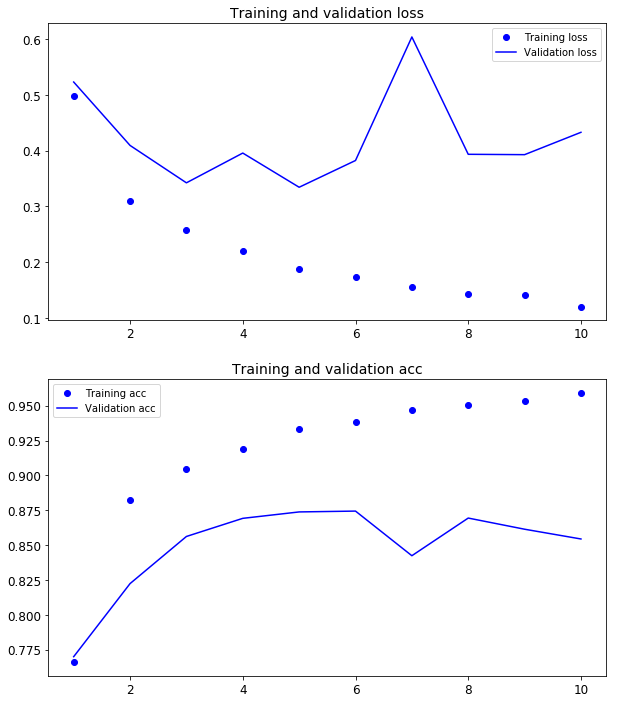

In [33]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
axes[0].set_title("Training and validation loss", fontsize=14)
axes[0].legend()

axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].set_title("Training and validation acc", fontsize=14)
axes[1].legend()

plt.show()

+ 使用双向RNN

In [34]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 158s 8ms/step - loss: 0.5580 - acc: 0.7190 - val_loss: 0.8829 - val_acc: 0.6258
Epoch 2/10
20000/20000 [==============================] - 157s 8ms/step - loss: 0.3344 - acc: 0.8734 - val_loss: 0.3230 - val_acc: 0.8692
Epoch 3/10
20000/20000 [==============================] - 157s 8ms/step - loss: 0.2688 - acc: 0.9012 - val_loss: 0.3834 - val_acc: 0.8684
Epoch 4/10
20000/20000 [==============================] - 156s 8ms/step - loss: 0.2281 - acc: 0.9200 - val_loss: 0.2999 - val_acc: 0.8844
Epoch 5/10
20000/20000 [==============================] - 156s 8ms/step - loss: 0.2097 - acc: 0.9288 - val_loss: 0.3455 - val_acc: 0.8826
Epoch 6/10
20000/20000 [==============================] - 156s 8ms/step - loss: 0.1899 - acc: 0.9360 - val_loss: 0.4575 - val_acc: 0.8388
Epoch 7/10
20000/20000 [==============================] - 157s 8ms/step - loss: 0.1706 - acc: 0.9414 - val_loss: 0.3980 - v

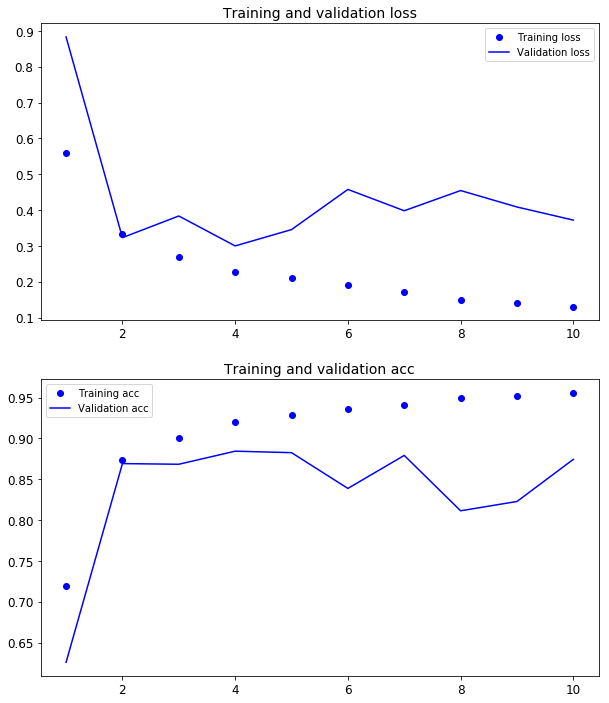

In [35]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
axes[0].set_title("Training and validation loss", fontsize=14)
axes[0].legend()

axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].set_title("Training and validation acc", fontsize=14)
axes[1].legend()

plt.show()

+ 将双向GRU应用于温度预测问题

In [36]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32),
                               input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 230s 460ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 228s 457ms/step - loss: 0.2743 - val_loss: 0.2727
Epoch 3/40
500/500 [==============================] - 228s 457ms/step - loss: 0.2665 - val_loss: 0.2717
Epoch 4/40
500/500 [==============================] - 228s 456ms/step - loss: 0.2627 - val_loss: 0.2709
Epoch 5/40
500/500 [==============================] - 229s 457ms/step - loss: 0.2549 - val_loss: 0.2720
Epoch 6/40
500/500 [==============================] - 229s 458ms/step - loss: 0.2483 - val_loss: 0.2713
Epoch 7/40
500/500 [==============================] - 229s 458ms/step - loss: 0.2444 - val_loss: 0.2795
Epoch 8/40
500/500 [==============================] - 229s 458ms/step - loss: 0.2394 - val_loss: 0.2783
Epoch 9/40
500/500 [==============================] - 230s 459ms/step - loss: 0.2328 - val_loss: 0.2816
Epoch 10/40
500/500 [==============================] - 229s 459m

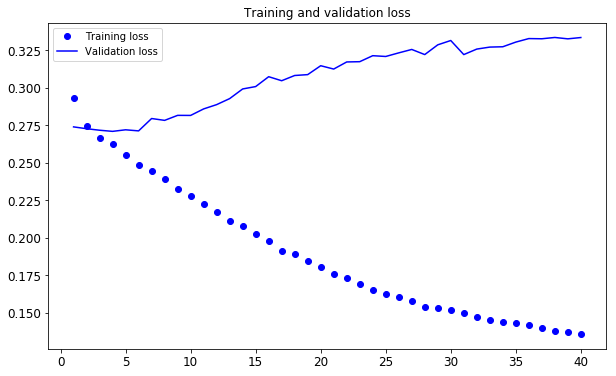

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

**双向RNN从两个方向查看一个序列，对自然语言处理问题非常有用。但如果在序列数据中最近的数据比序列开头包含更多的信息，那么这种方法的效果就不明显。**

**为提高温度预测问题的性能，可以尝试：**
1. 在堆叠循环层中调节每层的单元个数。当前取值在很大程度上是任意选择的，因此可能不是最优的。
2. 调节RMSprop优化器的学习率。
3. 尝试使用LSTM层代替GRU层。
4. 在循环层上面尝试使用更大的密集连接回归器，即更大的Dense层或Dense层堆叠。
5. 最后在测试集上运行性能最佳的模型（即验证MAE最小的模型）。否则，开发的网络架构将会对验证集过拟合。